In [102]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import os

## Constantes

In [79]:
PATH_TRICHODERMA = "redes/Trichoderma_atroviride/"
PATH_SECUENCIAS_TRICHODERMA = "secuencias_prufer/trichoderma_atroviride/"
REDES_TRICHODERMA = {1:["Muestra1_M1T24h","Muestra1_M1T26h","Muestra1_M1T28h","Muestra1_M1T30h","Muestra1_M1T32h"],
    2:["Muestra2_M2T24h","Muestra2_M2T26h","Muestra2_M2T28h","Muestra2_M2T30h","Muestra2_M2T32h"],
    3:["Muestra3_M3T26h","Muestra3_M3T28h","Muestra3_M3T30h","Muestra3_M3T32h","Muestra3_M3T34h","Muestra3_M3T36h"],
    4:["Muestra4_M4T26h","Muestra4_M4T28h","Muestra4_M4T30h","Muestra4_M4T32h","Muestra4_M4T34h","Muestra4_M4T36h"],
    5:["Muestra5_M5T26h","Muestra5_M5T28h","Muestra5_M5T30h","Muestra5_M5T32h","Muestra5_M5T36h"]
}

In [81]:
PATH_NEUROSPORA = "redes/Neurospora_crassa/"
PATH_SECUENCIAS_NEUROSPORA = "secuencias_prufer/neurospora_crassa/"
REDES_NEUROSPORA = {1:["Muestra1_M1N17h","Muestra1_M1N18h","Muestra1_M1N20h","Muestra1_M1N22h","Muestra1_M1N24h"],
    2:["Muestra2_M2N18h","Muestra2_M2N20h","Muestra2_M2N22h","Muestra2_M2N24h"],
    3:["Muestra3_M3N17h","Muestra3_M3N18h","Muestra3_M3N20h","Muestra3_M3N22h","Muestra3_M3N24h"],
    4:["Muestra4_M4N17h","Muestra4_M4N18h","Muestra4_M4N20h","Muestra4_M4N22h","Muestra4_M4N24h"],
    5:["Muestra5_M5N18h","Muestra5_M5N20h","Muestra5_M5N22h","Muestra5_M5N24h"]
}


In [52]:
nodos_trichoderma = {1: [24, 68 , 84 , 148, 294],
                    2: [8, 16, 24, 62, 150],
                    3: [14, 42, 68, 160, 356, 788],
                    4: [18,24, 50,104, 268, 606],
                    5: [14,18,42,108,422]}
nodos_neurospora = {1: [42, 54 , 102 , 226, 663 ],
                    2: [44, 110, 226, 758,],
                    3: [6, 24, 50, 128, 338],
                    4: [58, 84, 202, 518, 1578],
                    5: [48, 100, 280, 790],
                    }

## Árbol balanceado

In [4]:
def generar_arbol_regular_balanceado(k=3, altura=2):
    G = nx.Graph()
    node_id = 0
    edges = []
    niveles = [[node_id]]
    node_id += 1

    for _ in range(altura):
        nivel_actual = []
        for padre in niveles[-1]:
            hijos = [node_id + i for i in range(k)]
            edges.extend((padre, h) for h in hijos)
            nivel_actual.extend(hijos)
            node_id += k
        niveles.append(nivel_actual)
    G.add_edges_from(edges)
    return G

In [5]:
def dibujar_arbol(G, titulo,pos, node_labels):
    nx.draw(G, pos, node_size=600)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='white')
    plt.title(titulo)
    plt.show()

# Etiquetado por centralidad

In [78]:
def etiquetado_por_centralidad(G, centralidad, weighted):
    if centralidad == 0:
        if weighted:
            centralidad = dict(G.degree(weight="weight"))
        else:
            centralidad = dict(G.degree())
    elif centralidad == 1:
        centralidad = nx.degree_centrality(G)
    elif centralidad == 2:
        centralidad = nx.eigenvector_centrality(G)
    elif centralidad == 3:
        if weighted:
            centralidad = nx.closeness_centrality(G, distance="weight")
        else:
            centralidad = nx.closeness_centrality(G)
    elif centralidad == 4:
        if weighted:
            centralidad = nx.betweenness_centrality(G, weight="weight")
        else:
            centralidad = nx.betweenness_centrality(G)
    elif centralidad == 5:
        if weighted:
            centralidad = nx.pagerank(G, weight="weight")
        else:
            centralidad = nx.pagerank(G)
    elif centralidad == 6:
        if weighted:
            centralidad = nx.katz_centrality(G, weight="weight")
        else:
            centralidad = nx.katz_centrality(G)
    elif centralidad == 7:
        if weighted:
            centralidad = nx.current_flow_betweenness_centrality(G, weight="weight")
        else:
            centralidad = nx.current_flow_betweenness_centrality(G)
    elif centralidad == 8:
        if weighted:
            centralidad = nx.load_centrality(G, weight="weight")
        else:
            centralidad = nx.load_centrality(G)
    elif centralidad == 9:
        if weighted:
            centralidad = nx.harmonic_centrality(G, distance="weight")
        else:
            centralidad = nx.harmonic_centrality(G)
    else:
        return None
    centralidad_ordenada = sorted(centralidad.items(), key=lambda item: item[1])
    #print(centralidad_ordenada)
    node_labels = {centralidad_ordenada[i][0]:i for i in range(len(centralidad_ordenada))}
    return node_labels

## Lee las redes

In [28]:
def prufer_sequence_from_tree(edges):
    """
    Obtiene la sucesión de Prüfer de un árbol dado.

    Parámetros:
      - edges: lista de tuplas (u, v) que representan las aristas de un árbol etiquetado.

    Retorna:
      - prufer_seq: lista que representa la sucesión de Prüfer del árbol.
    """
    # 1. Determinar el conjunto de nodos y el número total de vértices.
    nodes = set()
    for u, v in edges:
        nodes.add(u)
        nodes.add(v)
    n = len(nodes)

    # 2. Crear la lista de adyacencia y calcular el grado de cada nodo.
    adj = {node: [] for node in nodes}
    degree = {node: 0 for node in nodes}

    for u, v in edges:
        adj[u].append(v)
        adj[v].append(u)
        degree[u] += 1
        degree[v] += 1

    # 3. Inicializar un heap (min-heap) con todas las hojas (nodos con grado 1)
    heap = []
    for node in nodes:
        if degree[node] == 1:
            heapq.heappush(heap, node)

    prufer_seq = []

    # 4. Realizar n-2 iteraciones para construir la sucesión de Prüfer.
    for _ in range(n - 2):
        # a) Extraer la hoja de menor etiqueta.
        leaf = heapq.heappop(heap)

        # b) Su hoja tendrá un único vecino; se toma el primer (y único) de su lista de adyacencia.
        neighbor = adj[leaf][0]
        prufer_seq.append(neighbor)

        # c) Actualizar el grado del vecino, eliminando la conexión con la hoja.
        degree[neighbor] -= 1
        adj[neighbor].remove(leaf)

        # d) La hoja se elimina del árbol; (podríamos marcarla con grado 0).
        degree[leaf] = 0

        # e) Si el vecino ahora es una hoja (grado 1), se agrega al heap.
        if degree[neighbor] == 1:
            heapq.heappush(heap, neighbor)

    return prufer_seq

In [103]:
def muestra_secuencias(secuencias, etiquetas, tipo_hongo):
    plt.figure(figsize=(8, 8))
    for i, seq in enumerate(secuencias):
        #plt.plot(seq, label=etiquetas[i], marker=".", linestyle="-")
        plt.scatter(range(len(seq)), seq, label=etiquetas[i], marker=".", linestyle="-")
    plt.xlabel("Índice en la secuencia")
    plt.ylabel("Etiqueta del vértice")
    if weighted:
        titulo = tipo_hongo + "_" + TIPO[CENTRALIDAD] + "_weighted"
    else:
        titulo = tipo_hongo + "_" + TIPO[CENTRALIDAD] + "_unweighted"
    plt.title(titulo)
    plt.legend()
    plt.grid()
    # Crear la carpeta si no existe
    os.makedirs(path_secuencias + TIPO[CENTRALIDAD] + "_weighted/", exist_ok=True)
    plt.savefig(path_secuencias + TIPO[CENTRALIDAD] + "_weighted/" + titulo + "_m" + str(muestra) + ".png")
    plt.show()


In [104]:
#---- Trichoderma atroviride ---
path_red = PATH_TRICHODERMA
redes = REDES_TRICHODERMA
titulo = "Trichoderma_Atroviride"
nodos_red = nodos_trichoderma
path_secuencias = PATH_SECUENCIAS_TRICHODERMA

#---- Neurospora crassa ---
#path_red = PATH_NEUROSPORA
#redes = REDES_NEUROSPORA
#titulo = "Neurospora_Crassa"
#nodos_red = nodos_neurospora
#path_secuencias = PATH_SECUENCIAS_NEUROSPORA

# Centralidades que no considerar pesos: Degree centrality,
# Centralidades que no convergen con pesos: Eigenvector, Katz
weighted = False
CENTRALIDAD = 9
TIPO = {0: "Degree", 1:"Degree centrality", 2: "Eigenvector", 3: "Closeness", 4: "Betweenness", 
        5: "PageRank", 6: "Katz", 7: "Current Flow Betweenness", 8: "Load", 9: "Harmonic"}

**** Procesando red: Muestra1_M1T24h con 24 nodos y 24 aristas.
Es árbol:  False
**** Procesando red: Muestra1_M1T26h con 68 nodos y 70 aristas.
Es árbol:  False
**** Procesando red: Muestra1_M1T28h con 84 nodos y 86 aristas.
Es árbol:  False
**** Procesando red: Muestra1_M1T30h con 148 nodos y 152 aristas.
Es árbol:  False
**** Procesando red: Muestra1_M1T32h con 294 nodos y 314 aristas.
Es árbol:  False


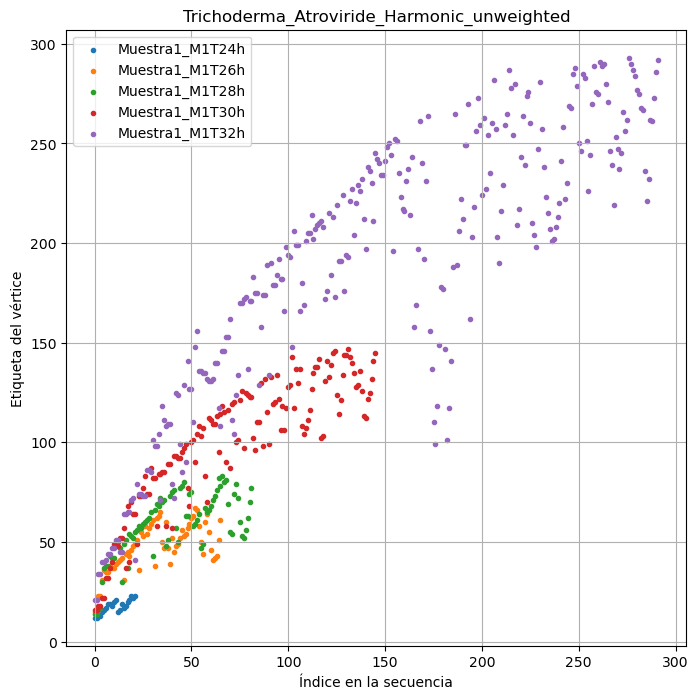

**** Procesando red: Muestra2_M2T24h con 8 nodos y 7 aristas.
Es árbol:  True
**** Procesando red: Muestra2_M2T26h con 16 nodos y 15 aristas.
Es árbol:  True
**** Procesando red: Muestra2_M2T28h con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando red: Muestra2_M2T30h con 62 nodos y 62 aristas.
Es árbol:  False
**** Procesando red: Muestra2_M2T32h con 150 nodos y 159 aristas.
Es árbol:  False


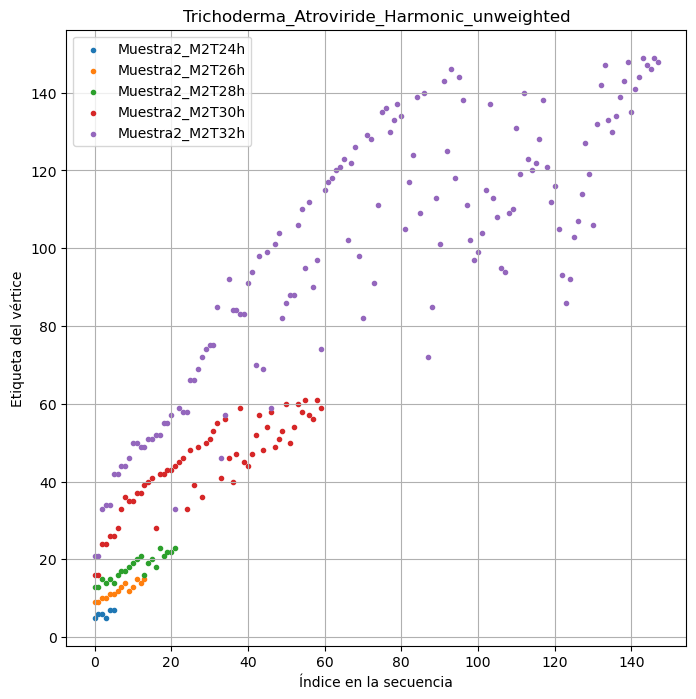

**** Procesando red: Muestra3_M3T26h con 14 nodos y 13 aristas.
Es árbol:  True
**** Procesando red: Muestra3_M3T28h con 42 nodos y 41 aristas.
Es árbol:  True
**** Procesando red: Muestra3_M3T30h con 68 nodos y 68 aristas.
Es árbol:  False
**** Procesando red: Muestra3_M3T32h con 160 nodos y 178 aristas.
Es árbol:  False
**** Procesando red: Muestra3_M3T34h con 356 nodos y 403 aristas.
Es árbol:  False
**** Procesando red: Muestra3_M3T36h con 788 nodos y 953 aristas.
Es árbol:  False


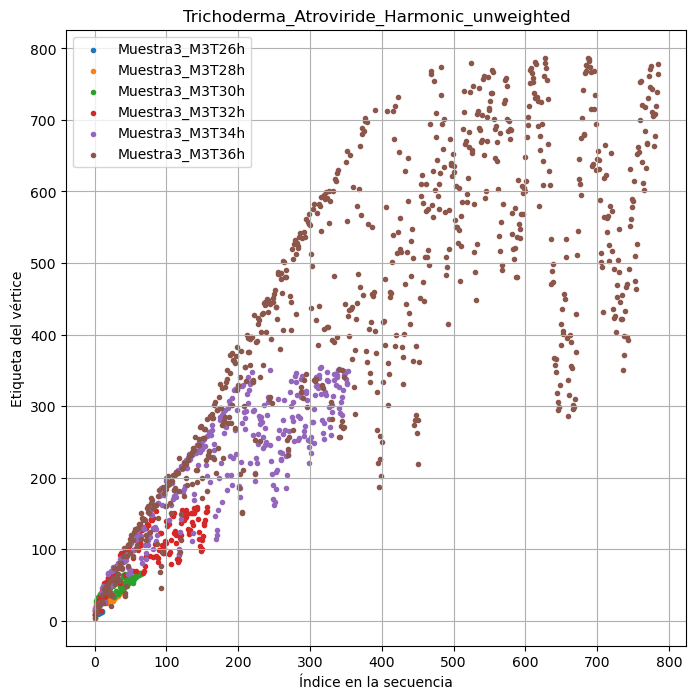

**** Procesando red: Muestra4_M4T26h con 18 nodos y 17 aristas.
Es árbol:  True
**** Procesando red: Muestra4_M4T28h con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando red: Muestra4_M4T30h con 50 nodos y 50 aristas.
Es árbol:  False
**** Procesando red: Muestra4_M4T32h con 104 nodos y 106 aristas.
Es árbol:  False
**** Procesando red: Muestra4_M4T34h con 268 nodos y 288 aristas.
Es árbol:  False
**** Procesando red: Muestra4_M4T36h con 606 nodos y 675 aristas.
Es árbol:  False


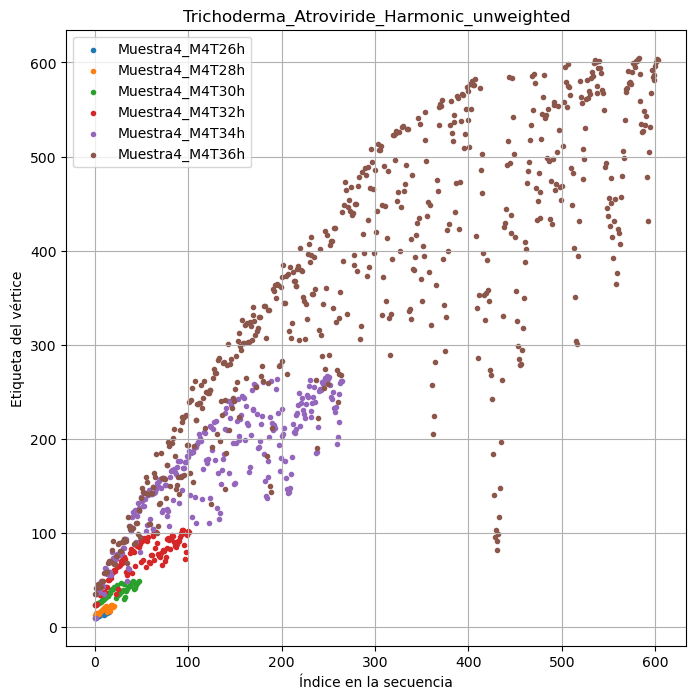

**** Procesando red: Muestra5_M5T26h con 14 nodos y 13 aristas.
Es árbol:  True
**** Procesando red: Muestra5_M5T28h con 18 nodos y 17 aristas.
Es árbol:  True
**** Procesando red: Muestra5_M5T30h con 42 nodos y 41 aristas.
Es árbol:  True
**** Procesando red: Muestra5_M5T32h con 108 nodos y 108 aristas.
Es árbol:  False
**** Procesando red: Muestra5_M5T36h con 432 nodos y 476 aristas.
Es árbol:  False


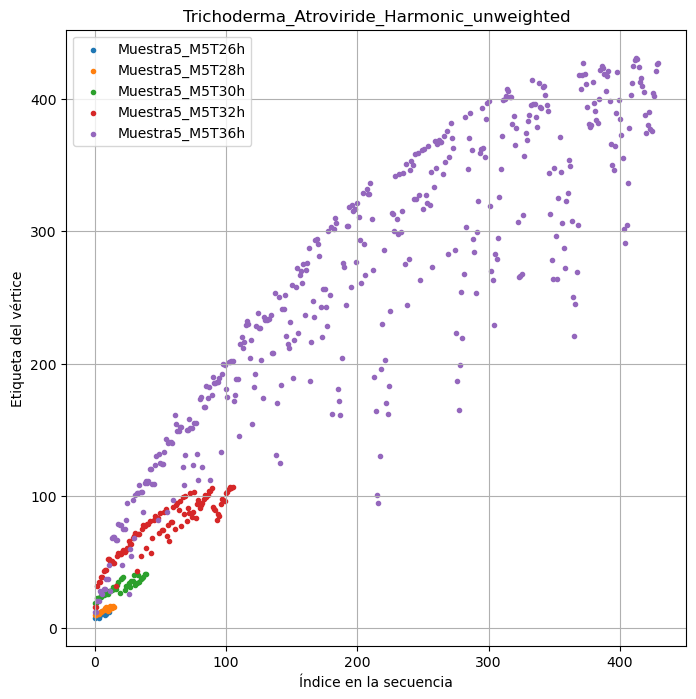

In [105]:
for muestra in range(1,6):
    prufer_seq = list()
    for red in redes[muestra]:
        G = nx.read_gexf(path_red + red + ".gexf")
        print("**** Procesando red:", red, "con", G.number_of_nodes(), "nodos y", G.number_of_edges(), "aristas.")
        print("Es árbol: ", nx.is_tree(G))
        if not nx.is_tree(G):
            T = nx.minimum_spanning_tree(G)
            node_labels = etiquetado_por_centralidad(G, CENTRALIDAD,weighted)
            H=T.copy()
        else:
            node_labels = etiquetado_por_centralidad(G, CENTRALIDAD,weighted)
            H=G.copy()
        if node_labels != None:
            G_relabelled = nx.relabel_nodes(H, node_labels, copy=True)
        else:
            print("No genero etiquetas")
        ps = prufer_sequence_from_tree(G_relabelled.edges())
        pos = {n:(G.nodes[n]['x'],G.nodes[n]['y']) for n in G.nodes()}
        #dibujar_arbol(G, red,pos, node_labels)
        #print("Secuencia de Prüfer:", ps)
        prufer_seq.append(ps)
    muestra_secuencias(prufer_seq, redes[muestra], titulo)


## Secuencia de un árbol aleatorio

**** Procesando árbol aleatorio con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 68 nodos y 67 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 84 nodos y 83 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 148 nodos y 147 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 294 nodos y 293 aristas.
Es árbol:  True


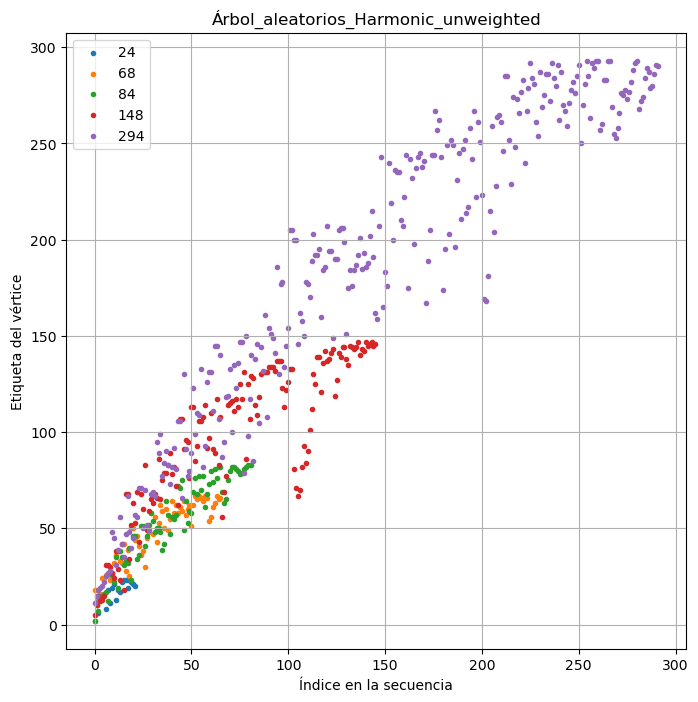

**** Procesando árbol aleatorio con 8 nodos y 7 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 16 nodos y 15 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 62 nodos y 61 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 150 nodos y 149 aristas.
Es árbol:  True


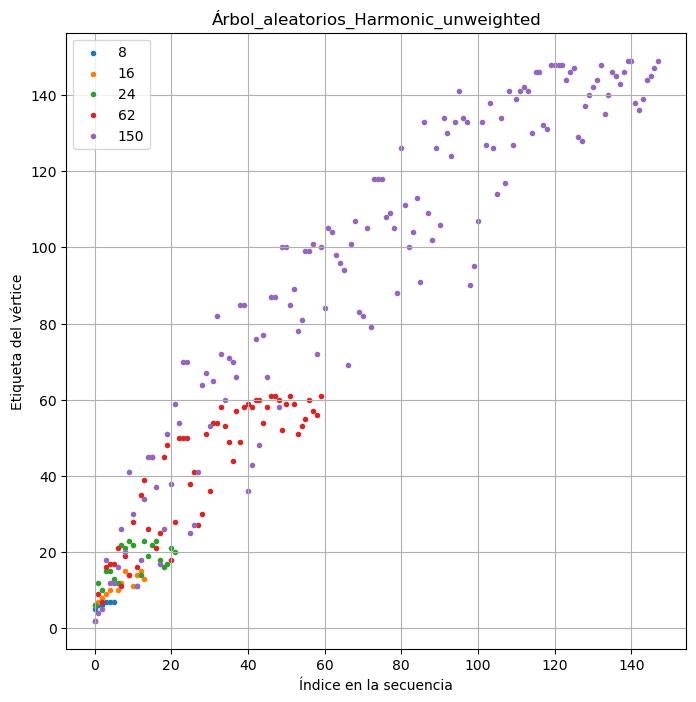

**** Procesando árbol aleatorio con 14 nodos y 13 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 42 nodos y 41 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 68 nodos y 67 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 160 nodos y 159 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 356 nodos y 355 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 788 nodos y 787 aristas.
Es árbol:  True


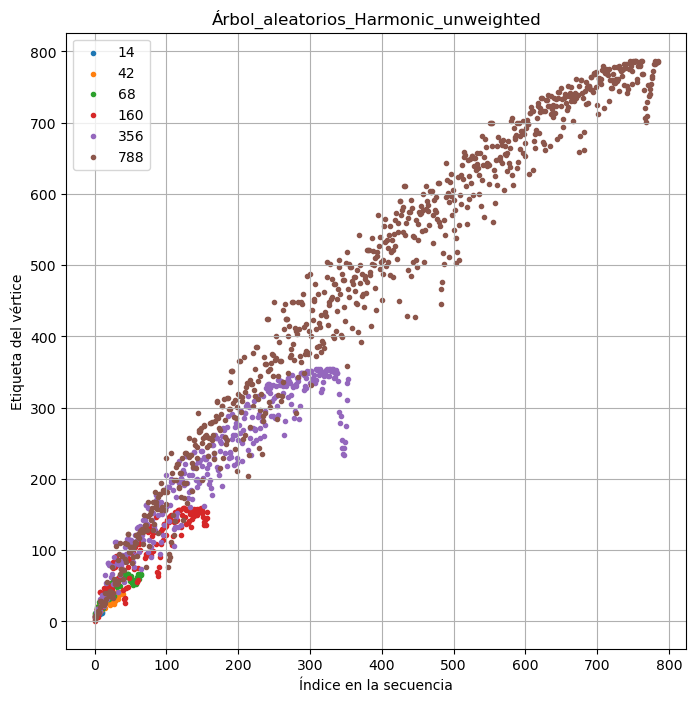

**** Procesando árbol aleatorio con 18 nodos y 17 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 50 nodos y 49 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 104 nodos y 103 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 268 nodos y 267 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 606 nodos y 605 aristas.
Es árbol:  True


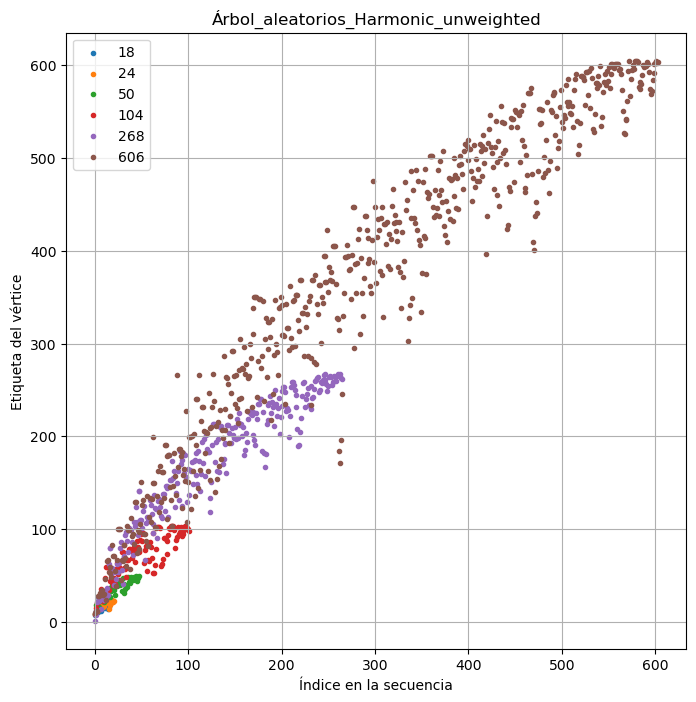

**** Procesando árbol aleatorio con 14 nodos y 13 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 18 nodos y 17 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 42 nodos y 41 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 108 nodos y 107 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 422 nodos y 421 aristas.
Es árbol:  True


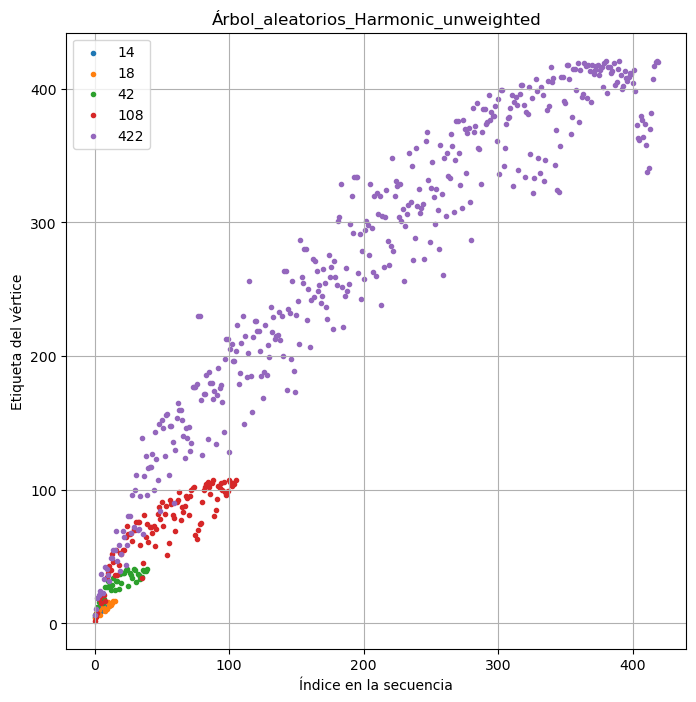

In [ ]:
for i in range(1,6):
    prufer_seq = list()
    for n in nodos_red[i]:
        G = nx.generators.random_tree(n)
        print("**** Procesando árbol aleatorio con", G.number_of_nodes(), "nodos y", G.number_of_edges(), "aristas.")
        print("Es árbol: ", nx.is_tree(G))
        node_labels = etiquetado_por_centralidad(G, CENTRALIDAD, weighted)
        G_relabelled = nx.relabel_nodes(G, node_labels, copy=True)
        ps = prufer_sequence_from_tree(G_relabelled.edges())
        #dibujar_arbol(G, red,pos, node_labels)
        #print("Secuencia de Prüfer:", ps)
        prufer_seq.append(ps)
    muestra_secuencias(prufer_seq, nodos_red[i], "Árbol_aleatorio")

**** Procesando red: Muestra5_M5T36h con 13 nodos y 12 aristas.
Es árbol:  True


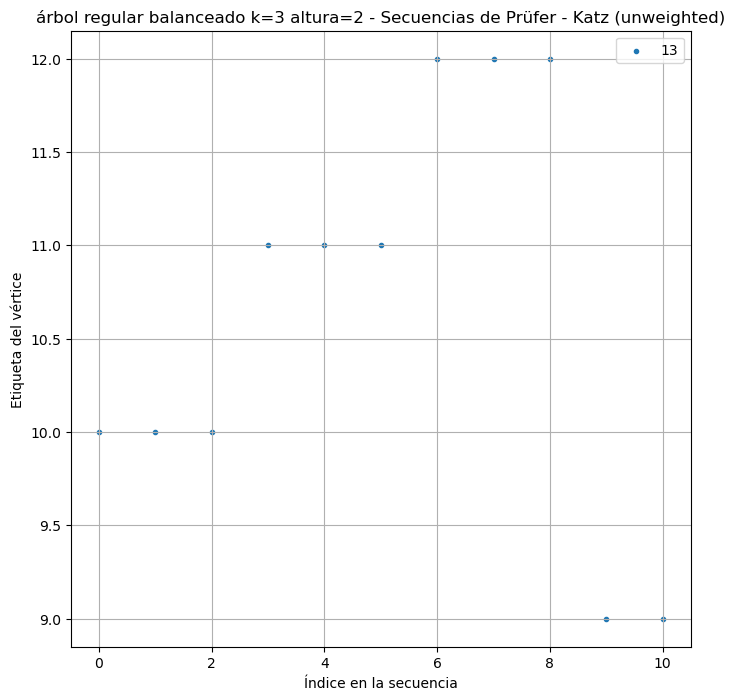

In [55]:
k=3
altura=2
G = generar_arbol_regular_balanceado(k, altura)
n = G.number_of_nodes()
print("**** Procesando red:", red, "con", n, "nodos y", G.number_of_edges(), "aristas.")
print("Es árbol: ", nx.is_tree(G))
node_labels = etiquetado_por_centralidad(G, CENTRALIDAD, weighted)
G_relabelled = nx.relabel_nodes(G, node_labels, copy=True)
ps = prufer_sequence_from_tree(G_relabelled.edges())
#dibujar_arbol(G, red,pos, node_labels)
#print("Secuencia de Prüfer:", ps)
muestra_secuencias([ps],[n], "árbol regular balanceado k=" + str(k) + " altura=" + str(altura))

In [51]:
import random
def sample_with_replacement(population, k):
    """Returns a sample of size ``k`` from the given population.

    ``population`` must be a sequence and ``k`` must be a positive
    integer.

    This function returns a list of ``k`` elements chosen uniformly at
    random from ``population``.

    """
    return [random.choice(population) for i in range(k)]
n= 10
sequence = sample_with_replacement(range(n), n - 2)
print("Secuencia de Prüfer aleatoria:", sequence)
T = nx.from_prufer_sequence(sequence)
diametro = nx.diameter(T)
print("Diámetro del árbol generado a partir de la secuencia de Prüfer aleatoria:", diametro)
for i in range(1,100):
    x = sequence.count(i)
    if x > 3:
        print("Cuántos ", i ," hay ", sequence.count(i))

Secuencia de Prüfer aleatoria: [3, 2, 4, 3, 1, 6, 7, 7]
Diámetro del árbol generado a partir de la secuencia de Prüfer aleatoria: 7
